### <font color='indigo'>1) Import the Required Packages and Load the Dataset

In [19]:
# Install TabNet
# !pip install pytorch-tabnet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import optuna

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from optuna import Trial, visualization

In [2]:
# Load and Display Data
pd.set_option('display.float_format',  '{:,}'.format)
pd.options.display.max_rows = 8
df = pd.read_csv("CR1_Data_Processed.csv", header=0, skiprows=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   loan_intent                 32574 non-null  object 
 4   loan_grade                  32574 non-null  object 
 5   loan_amnt                   32574 non-null  int64  
 6   loan_status                 32574 non-null  int64  
 7   loan_percent_income         32574 non-null  float64
 8   cb_person_default_on_file   32574 non-null  object 
 9   cb_person_cred_hist_length  32574 non-null  int64  
 10  loan_int_rate               32574 non-null  float64
 11  person_emp_length           32574 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   loan_intent                 32574 non-null  object 
 4   loan_grade                  32574 non-null  object 
 5   loan_amnt                   32574 non-null  int64  
 6   loan_status                 32574 non-null  int64  
 7   loan_percent_income         32574 non-null  float64
 8   cb_person_default_on_file   32574 non-null  object 
 9   cb_person_cred_hist_length  32574 non-null  int64  
 10  loan_int_rate               32574 non-null  float64
 11  person_emp_length           32574 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### <font color='indigo'>2) Data Preparation for the Model

* The categorical variables need to be encoded so that they can be used in models.

In [4]:
df_num = df.select_dtypes(include=["number"]) #numerical columns of df
df_cat = df.select_dtypes(include=["object"]) #categorical columns of df
cat_cols = df_cat.columns #name of categorical columns

#Label encoding of categorical columns
for i in cat_cols:
    labelencoder = LabelEncoder()
    df_cat[i] = labelencoder.fit_transform(df_cat[i])

df = pd.concat([df_num,df_cat], axis=1)

df.head()

,person_age,person_income,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_emp_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,21,9600,1000,0,0.1,2,11.14,5.0,2,1,1,0
1,25,9600,5500,1,0.57,3,12.87,1.0,0,3,2,0
2,23,65500,35000,1,0.53,2,15.23,4.0,3,3,2,0
3,24,54400,35000,1,0.55,4,14.27,8.0,3,3,2,1
4,21,9900,2500,1,0.25,2,7.14,2.0,2,5,0,0


#### Predictors-Target Split

In [5]:
X = df.drop(["loan_status"], axis=1) #predictors
Y = df[["loan_status"]] #target

#### Train-Valid-Test Split

* Splitting the whole dataset into three sets: train, validation, and test with ratios of 80%, 10%, and 10% respectively.

In [6]:
train_size=0.8
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8, random_state=777)

test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=777)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(26059, 11)
(26059, 1)
(3257, 11)
(3257, 1)
(3258, 11)
(3258, 1)


(None, None)

* We need to convert the pandas dataframes into numpy array for TabNet to process, it is how it is designed.

In [7]:
#turning them into numpy objects so as to be processed by the model
X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values

Y_train = Y_train.values.reshape(-1)
Y_valid = Y_valid.values.reshape(-1)
Y_test = Y_test.values.reshape(-1)

###  <font color='indigo'> 3) Model Building

In [8]:
target="loan_status"
features = [col for col in df.columns if col not in [target]] 

cat_idxs = [i for i, f in enumerate(features) if f in cat_cols]
cat_dims = list(dict(df[cat_cols].nunique()).values())

In [9]:
# Network parameters
max_epochs = 50 
batch_size = 256
model_tabnet = TabNetClassifier(n_d=64, n_a=64, n_steps=3, gamma=1.4, cat_idxs=cat_idxs, cat_dims=cat_dims,
                       cat_emb_dim=1, n_independent=2, n_shared=1, epsilon=1e-15, momentum=0.02,
                       lambda_sparse=0.000807661747303042, seed=0, clip_value=1, verbose=0,
                       optimizer_fn=torch.optim.Adam, optimizer_params={'lr': 0.02, 'weight_decay': 1e-05},
                       scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau, 
                       scheduler_params={'mode': 'min', 'patience': 10, 'min_lr': 1e-05, 'factor': 0.5})

In [10]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

class my_metric(Metric):
    """
    2xAUC.
    """
    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        return 2*roc_auc_score(y_true, y_score[:, 1])

In [11]:
model_tabnet.fit(
    X_train=X_train, y_train=Y_train,
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    eval_name=['train', 'val'],
    eval_metric=["auc", my_metric],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=my_loss_fn) 

C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


### <font color='indigo'>4) Model Performance Indicators

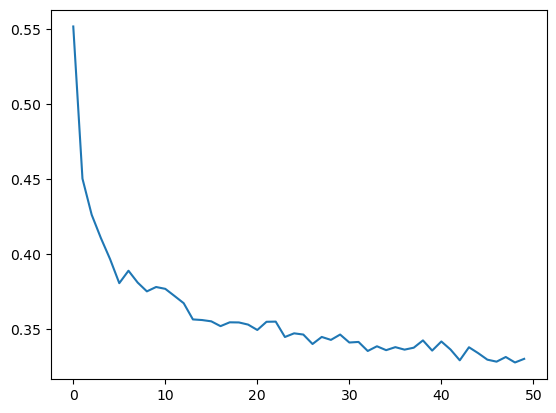

In [12]:
# plot losses
plt.plot(model_tabnet.history['loss'])

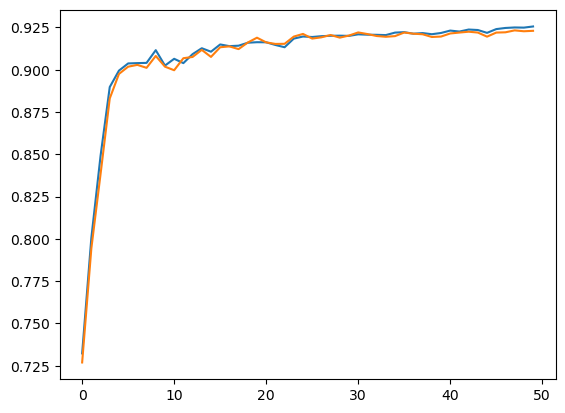

In [13]:
# plot auc
plt.plot(model_tabnet.history['train_auc'])
plt.plot(model_tabnet.history['val_auc'])

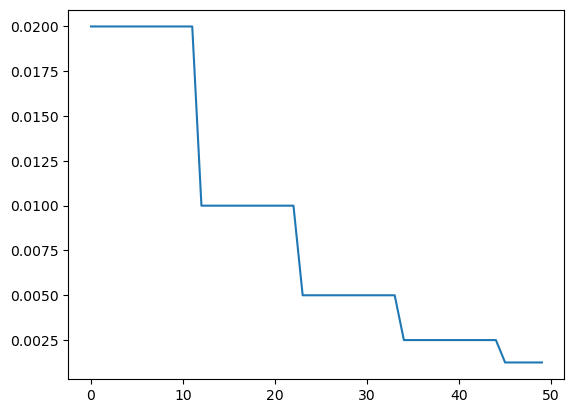

In [14]:
# plot learning rates
plt.plot(model_tabnet.history['lr'])

In [15]:
preds_train = model_tabnet.predict_proba(X_train)
train_auc = roc_auc_score(y_score=preds_train[:,1], y_true=Y_train)

preds_valid = model_tabnet.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=Y_valid)

preds = model_tabnet.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=Y_test)

print(f"FINAL TRAIN SCORE FOR OUR DATA IS : {train_auc}")
print(f"FINAL VALID SCORE FOR OUR DATA IS : {valid_auc}")

FINAL TRAIN SCORE FOR OUR DATA IS : 0.9256035875859642
FINAL VALID SCORE FOR OUR DATA IS : 0.9230351268137894


In [16]:
y_score = preds[:,1]
y_score_cat = np.where(y_score<0.5, 0, 1)
target_names = ['Non-Default', 'Default']

print(classification_report(Y_test, y_score_cat, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.93      0.93      2566
     Default       0.74      0.74      0.74       692

    accuracy                           0.89      3258
   macro avg       0.84      0.84      0.84      3258
weighted avg       0.89      0.89      0.89      3258



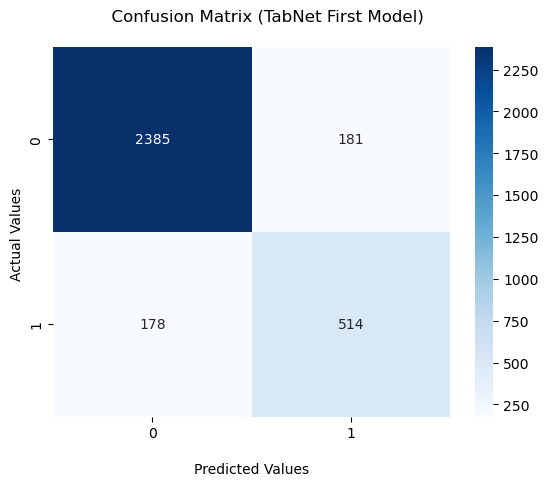

In [17]:
cm_first_model = confusion_matrix(Y_test, y_score_cat)
ax = sns.heatmap(cm_first_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix (TabNet First Model)\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

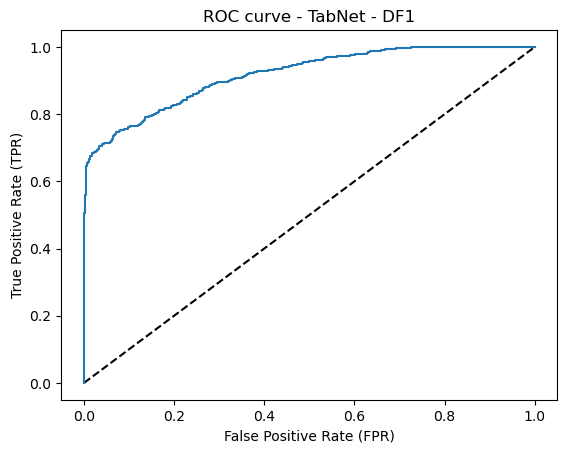

In [21]:
fpr, tpr, thresholds = roc_curve(Y_test, y_score)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - TabNet - DF1')
plt.show()

In [22]:
print(f"FINAL TEST SCORE FOR OUR DATA IS : {test_auc}")

FINAL TEST SCORE FOR OUR DATA IS : 0.9169677733275066


### <font color='indigo'>5) Hyperparameter tuning

In [24]:
df_hp = pd.get_dummies(df)
X = df_hp.drop(["loan_status"], axis=1).values #predictors
Y = df_hp[["loan_status"]].values #target
Y = Y.reshape(-1)

def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        Y_train, Y_valid = Y[train_index], Y[test_index]
        cls = TabNetClassifier(**tabnet_params)
        cls.fit(X_train=X_train, y_train=Y_train,
                  eval_set=[(X_valid, Y_valid)],
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                  eval_metric=['auc'])

    return cls

In [25]:
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60)

[I 2022-11-28 21:16:49,006] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 43 with best_epoch = 29 and best_val_0_auc = 0.92164


C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 43 with best_epoch = 41 and best_val_0_auc = 0.92615


C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 43 with best_epoch = 40 and best_val_0_auc = 0.90289


C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 43 with best_epoch = 40 and best_val_0_auc = 0.91072


C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 43 with best_epoch = 41 and best_val_0_auc = 0.91459


C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[W 2022-11-28 21:30:09,516] Trial 0 failed because of the following error: The value TabNetClassifier(n_d=56, n_a=56, n_steps=3, gamma=1.2, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.00014036356020415364, seed=0, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02, 'weight_decay': 1e-05}, scheduler_fn=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_params={'mode': 'min', 'patience': 10, 'min_lr': 1e-05, 'factor': 0.5}, mask_type='sparsemax', input_dim=11, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1) could not be cast to float.


### <font color='indigo'>6) Final Model

In [26]:
final_model_tabnet = TabNetClassifier(n_d=56, n_a=56, n_steps=3, gamma=1.2, cat_idxs=cat_idxs, cat_dims=cat_dims,
                                      cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02,
                                      lambda_sparse=0.00034311283603398896, seed=0, clip_value=1, verbose=0,
                                      optimizer_fn=torch.optim.Adam, optimizer_params={'lr': 0.02, 'weight_decay': 1e-05},
                                      scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                      scheduler_params={'mode': 'min', 'patience': 10, 'min_lr': 1e-05, 'factor': 0.5},
                                      mask_type='sparsemax', input_dim=11, output_dim=2, device_name='auto',
                                      n_shared_decoder=1, n_indep_decoder=1)

final_model_tabnet.fit(
    X_train=X_train, y_train=Y_train,
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    eval_name=['train', 'val'],
    eval_metric=["auc", my_metric],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    loss_fn=my_loss_fn) 

C:\Users\Dell\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [27]:
preds_train = final_model_tabnet.predict_proba(X_train)
train_auc = roc_auc_score(y_score=preds_train[:,1], y_true=Y_train)

preds_valid = final_model_tabnet.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=Y_valid)

preds = final_model_tabnet.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=Y_test)

print(f"FINAL TRAIN SCORE FOR OUR DATA IS : {train_auc}")
print(f"FINAL VALID SCORE FOR OUR DATA IS : {valid_auc}")

FINAL TRAIN SCORE FOR OUR DATA IS : 0.9217072316518812
FINAL VALID SCORE FOR OUR DATA IS : 0.9180176116549301


In [28]:
y_score_2 = preds[:,1]
y_score_cat_2 = np.where(y_score_2<0.5, 0, 1)
target_names = ['Non-Default', 'Default']

print(classification_report(Y_test, y_score_cat_2, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.96      0.95      2566
     Default       0.84      0.73      0.78       692

    accuracy                           0.91      3258
   macro avg       0.88      0.85      0.86      3258
weighted avg       0.91      0.91      0.91      3258



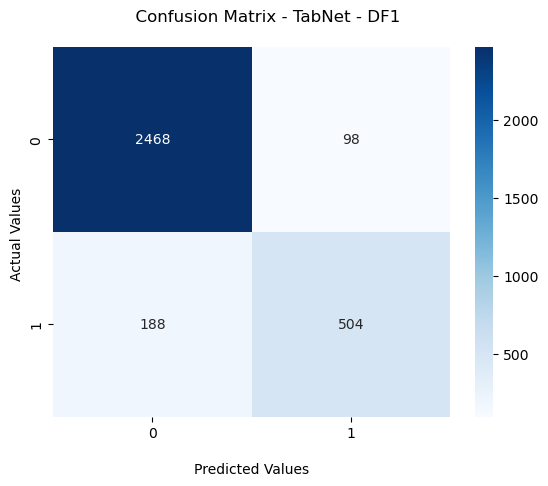

In [39]:
cm_final_model = confusion_matrix(Y_test, y_score_cat_2)
ax = sns.heatmap(cm_final_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix - TabNet - DF1\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

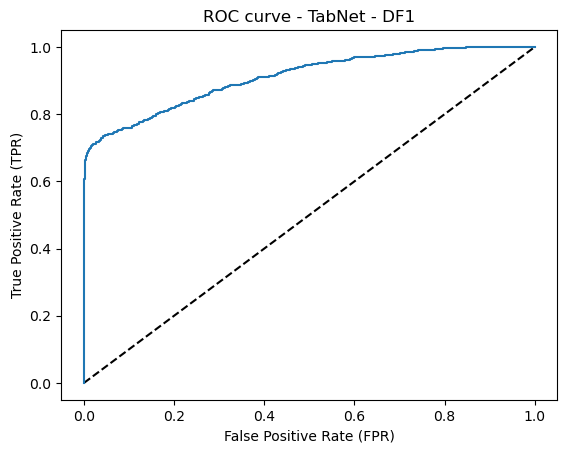

In [30]:
fpr, tpr, thresholds = roc_curve(Y_test, y_score_2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - TabNet - DF1')
plt.show()

In [31]:
print(f"FINAL TEST SCORE FOR OUR DATA IS : {test_auc}")

FINAL TEST SCORE FOR OUR DATA IS : 0.9101297987466155


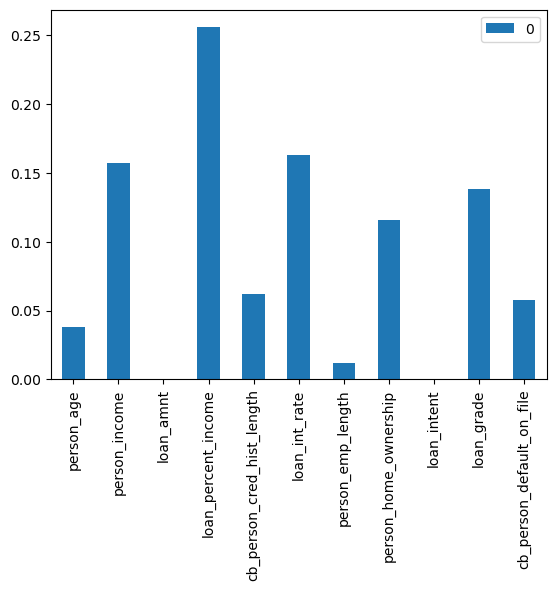

In [35]:
#Global explainability : feat importance summing to 1
pd.DataFrame(final_model_tabnet.feature_importances_, index=list(df.columns[:3])+list(df.columns[4:])).plot(kind="bar")
plt.show()

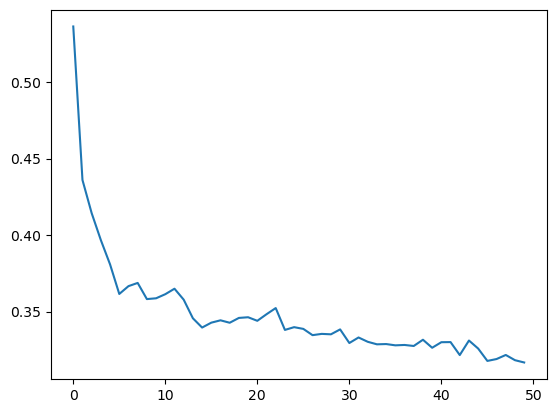

In [32]:
# plot losses
plt.plot(final_model_tabnet.history['loss'])
plt.show()

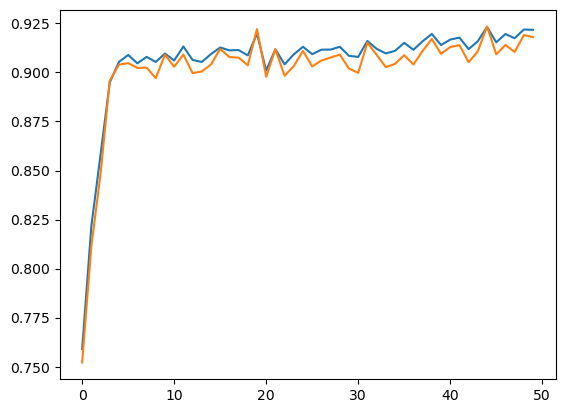

In [33]:
# plot auc
plt.plot(final_model_tabnet.history['train_auc'])
plt.plot(final_model_tabnet.history['val_auc'])
plt.show()

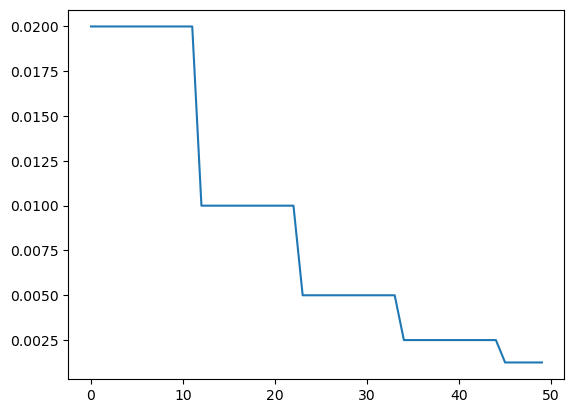

In [34]:
# plot learning rates
plt.plot(final_model_tabnet.history['lr'])